In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
import joblib
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve
random.seed(123)

## Loading data

In [2]:
# Loading data
df = pd.read_csv('RJ/dataset_ML_RJ.csv')
df_out = df[df['EPI_YEAR'] > 2020] # serve as final validation for concatenated model
df = df[df['EPI_YEAR'] <= 2020]
df_tplot = df['tplot']
df_cases = df['CASES_100K']
df = df.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df['label_2'] = 0 # for most of values, no epidemic yet
df.loc[df['label'] == 'Epi','label_2'] = 1 # epidemic
df.loc[df['label'] == 'High','label_2'] = 1 # epidemic as well
df = df.drop(columns = ['label'])
X = df.iloc[:,0:7]
y = df.iloc[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

Train:  (720,)
Test:  (154,)
Validation:  (155,)


## Loading the best model

In [3]:
grid_model = joblib.load('rj_xgboost.pkl')
thr_opt = 0.009829155

In [4]:
y_test_pred = grid_model.predict(X_test)
y_test_proba = grid_model.predict_proba(X_test)[:,1]
y_test_final = y_test_proba.copy()
y_test_final[y_test_proba >= thr_opt] = 1
y_test_final[y_test_proba < thr_opt] = 0

## Evaluating results - feature importance

### Embedded feature importance

Text(0.5, 0, 'Feature Importance')

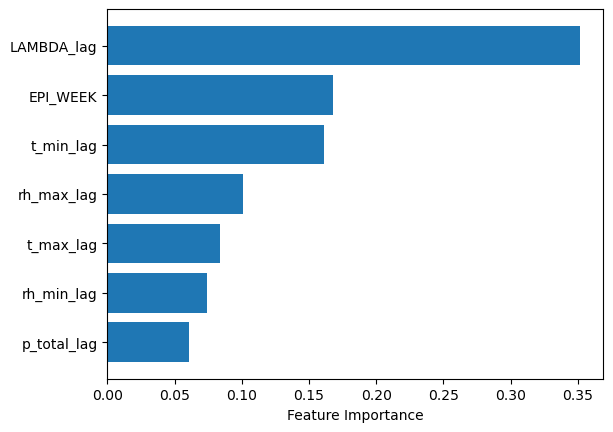

In [5]:
sorted_params = grid_model.feature_importances_.argsort()
plt.barh(df.columns[sorted_params], grid_model.feature_importances_[sorted_params])
plt.xlabel('Feature Importance')

### SHAP values on test dataset

In [6]:
explainer = shap.Explainer(grid_model)
shap_values = explainer(X_test)

#### Beeswarm plot

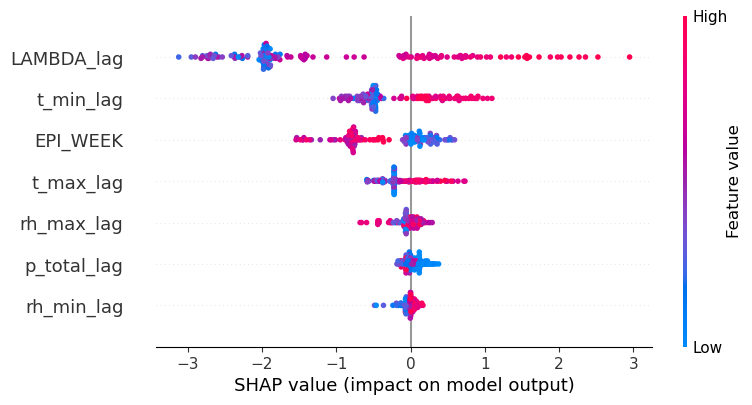

In [7]:
shap.plots.beeswarm(shap_values)

#### Absolute value plot

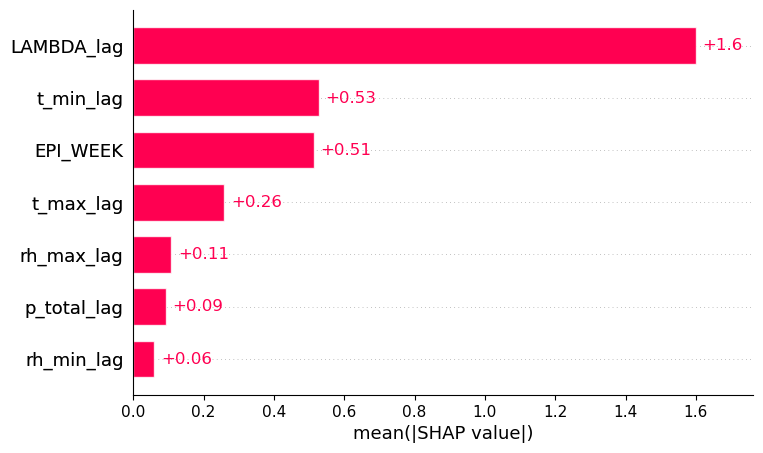

In [8]:
shap.plots.bar(shap_values)

## Visualizing results

In [9]:
y_pred_proba = grid_model.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [10]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))

In [11]:
Z = X.copy()
Z['label'] = 0

In [12]:
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'

In [13]:
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


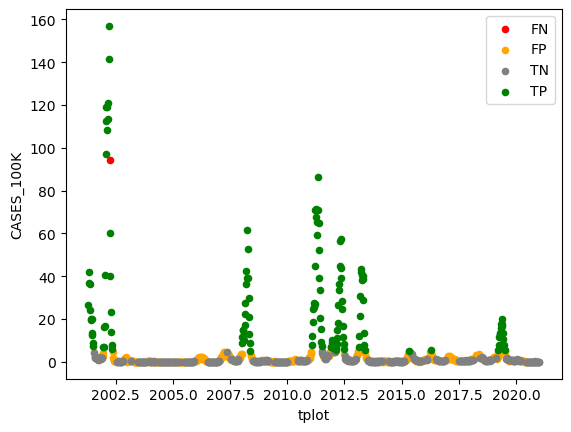

In [14]:
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()

In [15]:
print(sum(fn), sum(fp), sum(tp), sum(tn))

1 405 133 490


## Trying to reduce false positives the most - using probability

In [16]:
Z['proba'] = y_pred_proba

Text(0, 0.5, 'Count')

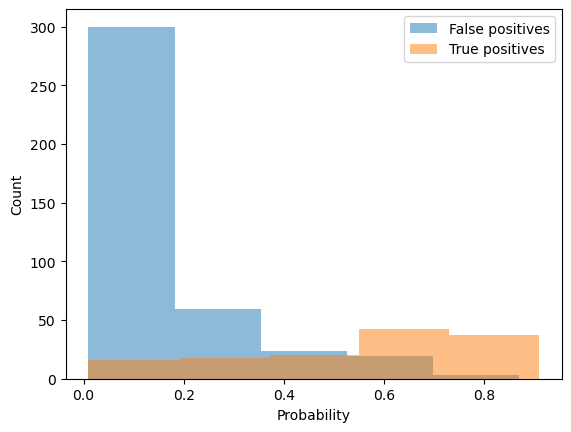

In [17]:
A = Z.copy()
A = A[A['label'] == 'FP']
B = Z.copy()
B = B[B['label'] == 'TP']
C = Z.copy()
C = C[C['label'] == 'TN']
plt.hist(A['proba'], bins = 5, alpha = 0.5, label = 'False positives')
plt.hist(B['proba'], bins = 5, alpha = 0.5, label = 'True positives')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Count')

0.15
0.49586776859504134
0.5041322314049587


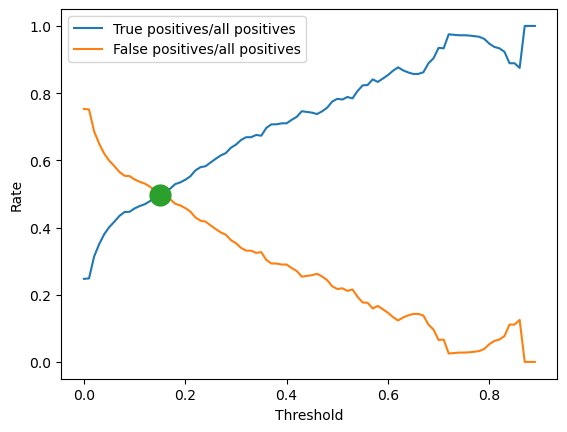

In [18]:
pos_thr = np.arange(0,0.9,0.01)
tpp_vec = []
fpp_vec = []
ex_sel = (y_pred_proba >= thr_opt) # selected examples
y_sel = y.loc[ex_sel] # getting all positives
y_sel_prob = y_pred_proba[ex_sel] # getting their probabilities
for thr in pos_thr:
    tpp_tmp = sum((y_sel_prob >= thr) & (y_sel == 1))/sum(y_sel_prob >= thr) # true positive proportion - true positives/all positives
    fpp_tmp = sum((y_sel_prob >= thr) & (y_sel == 0))/sum(y_sel_prob >= thr) # false positive proportion - false positives / all positives
    tpp_vec.append(tpp_tmp)
    fpp_vec.append(fpp_tmp)
plt.plot(pos_thr, tpp_vec, label = 'True positives/all positives')
plt.plot(pos_thr, fpp_vec, label = 'False positives/all positives')
plt.legend()
thr_arg = np.argmin(abs(np.array(tpp_vec) - np.array(fpp_vec)))
thr_new = pos_thr[thr_arg]
print(thr_new)
print(tpp_vec[thr_arg])
print(fpp_vec[thr_arg])
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.plot(np.array([thr_new]),np.array([tpp_vec[thr_arg]]),'o', markersize = 15)
plt.show()

### How does this look when correcting our previous results?

In [19]:
y_pred_proba = grid_model.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba < thr_opt] = 0
y_pred_final[(y_pred_proba >= thr_opt) & (y_pred_proba >= thr_new)] = 1
y_pred_final[(y_pred_proba >= thr_opt) & (y_pred_proba < thr_new)] = 0

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


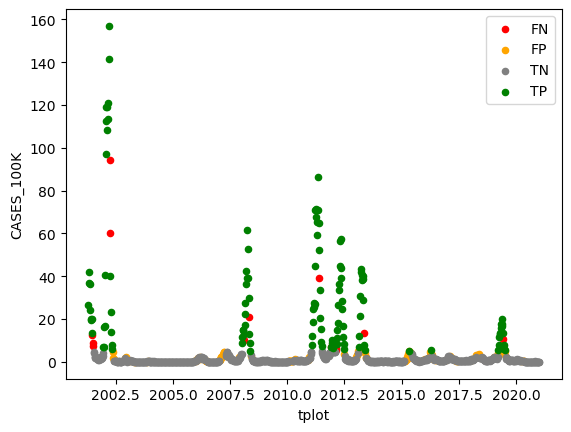

In [20]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))
Z = X.copy()
Z['label'] = 0
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()

In [21]:
print(sum(fn), sum(fp), sum(tp), sum(tn))

14 122 120 773


### And on data we have never seen before?

In [22]:
df_tplot = df_out['tplot']
df_cases = df_out['CASES_100K']
df_out = df_out.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df_out['label_2'] = 0 # for most of values, no epidemic yet
df_out.loc[df_out['label'] == 'Epi','label_2'] = 1 # epidemic
df_out.loc[df_out['label'] == 'High','label_2'] = 1 # epidemic as well
df_out = df_out.drop(columns = ['label'])
X_out = df_out.iloc[:,0:7]
y_out = df_out.iloc[:,7]

#### Using the base model now

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


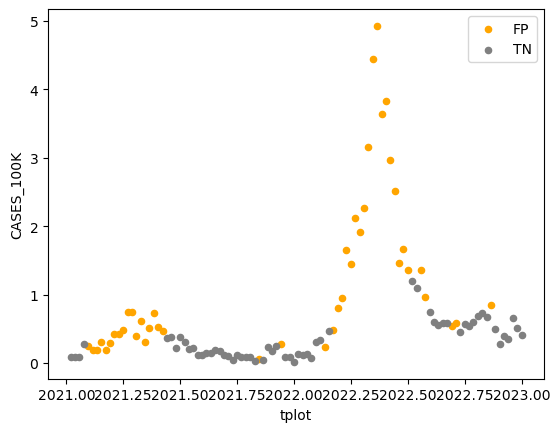

In [23]:
y_pred_proba = grid_model.predict_proba(X_out)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0
fn = ((y_out == 1) & (y_pred_final == 0))
fp = ((y_out == 0) & (y_pred_final == 1))
tn = ((y_out == 0) & (y_pred_final == 0))
tp = ((y_out == 1) & (y_pred_final == 1))
Z = X_out.copy()
Z['label'] = 0
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()

#### Using base model + basic classifier

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


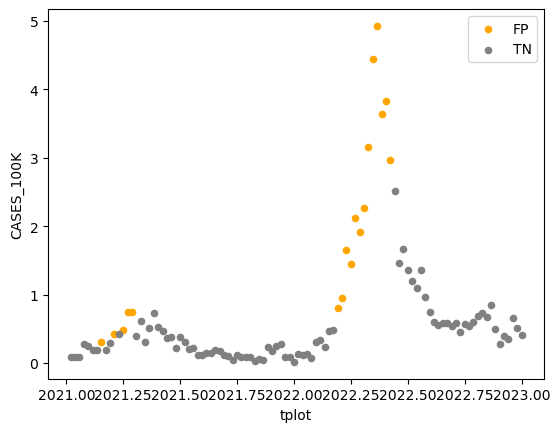

In [24]:
y_pred_proba = grid_model.predict_proba(X_out)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba < thr_opt] = 0
y_pred_final[(y_pred_proba >= thr_opt) & (y_pred_proba >= thr_new)] = 1
y_pred_final[(y_pred_proba >= thr_opt) & (y_pred_proba < thr_new)] = 0
fn = ((y_out == 1) & (y_pred_final == 0))
fp = ((y_out == 0) & (y_pred_final == 1))
tn = ((y_out == 0) & (y_pred_final == 0))
tp = ((y_out == 1) & (y_pred_final == 1))
Z = X_out.copy()
Z['label'] = 0
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()